# Algorithme de Metropolis et du recuit simulé

Dans une première partie, on utilise l'algorithme de Metropolis pour construire une chaine de Markov de probabilité invariante $\mu$ donnée.

Dans une deuxième partie, on implémente l'algorithme du recuit simulé pour optimiser une fonction sur un espace discret grand. Le problème d'optimisation considéré est celui du "voyageur de commerce" qui est un problème classique en optimisation discrète.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng
rng = default_rng()

## Algorithme de Metropolis

Soit $E$ un ensemble dénombrable et $\mu$ une probabilité sur $E$. L'algorithme de Metropolis permet de construire une chaîne de Markov de probabilité invariante $\mu$.

Soit $P$ une matrice stochastique, dite de sélection (ou de proposition), qui permet de parcourir l'espace d'état $E$ et $\rho$ la fonction définie par

$$
  \forall x, y \in E, \quad \rho(x, y)
  = \frac{\mu(y) P(y, x)}{\mu(x) P(x, y)} \wedge 1.
$$

On considère la matrice stochastique

$$
  Q(x, y) = \begin{cases}
      P(x, y) \rho(x, y) & \text{si $x \neq y$} \\
      1 - \sum_{z \neq x} Q(x, z) & \text{si $x = y$}.
  \end{cases}
$$

Alors sous les hypothèses adhoc, la chaine de Markov $(Y_n)_{n \ge 1}$ de transition $Q$ a pour unique probabilité invariante $\mu$ et $(Y_n)_{n \ge 1}$ converge en loi vers $\mu$.

## Petit exemple sur $\mathbf{Z}$

On considère la probabilité $\mu$ sur $E = \mathbf{Z}$ définie par

$$
  \forall x \in \mathbf{Z}, \quad \mu(x) = C \exp \bigl(-\frac{|x|}{5}\bigr).
$$

Soit $P$ la matrice de transition de la marche aléatoire symmétrique sur $\mathbf{Z}$ définie par $P(x, x-1) = P(x, x+1) = \frac{1}{2}$.

### Question: simulation de la chaine de transition $Q$

Ecrire la dynamique de la chaine $(Y_n)_{n \ge 0}$ de matrice de transition $Q$ (et de loi invariante $\mu$).  
Coder cette dynamique dans une fonction `phi` de sorte que l'appel suivant crée un échantillon de $1\,000$ trajectoires sur $\{0, \dots, 100\}$.
```{python}
n_steps = 101
n_paths = 1000

sample = np.zeros((n_steps, n_paths))
for n in range(1, n_steps):
    phi(sample[n-1], sample[n])
```

In [2]:
def mu(x):
    return np.exp(-np.abs(x)/5)

def phi(Xn, Xnp1):
    # candidat_y = Xn + 2*(rng.uniform(size=len(Xn)) < 0.5) -1
    candidat_y = Xn + rng.choice([1, -1], size=len(Xn), replace=True)       # tirage de +ou- 1 sur le step actuel

    rho = np.minimum( mu(candidat_y)/mu(Xn), 1)     # calcul de l'acceptation
    accept = rng.uniform(size=len(Xn))<rho      # matrice booléenne des voisins acceptés

    # modification des trajectoires acceptées / imobilisation sur les trajectoires refusées
    Xnp1[accept] = candidat_y[accept]
    Xnp1[~accept] = Xn[~accept]


### Question: trajectoires et histogramme

Visualiser quelques trajectoires de $(Y_n)_{n=0,\dots,1000}$ et comparer l'histogramme à l'itération 1000 avec la densité $\mu$.

In [3]:
n_steps = 101
n_paths = 1000

sample = np.zeros((n_steps, n_paths))
for n in range(1, n_steps):
    phi(sample[n-1], sample[n])

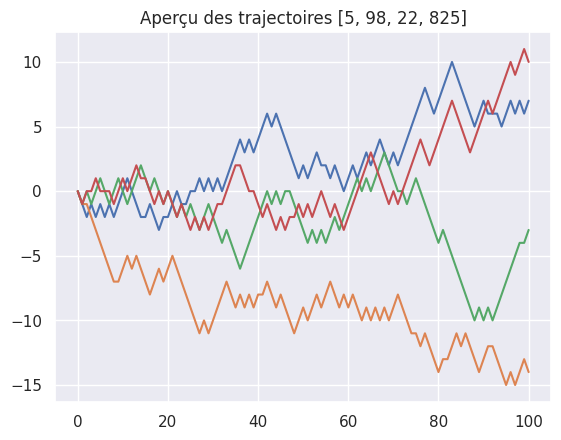

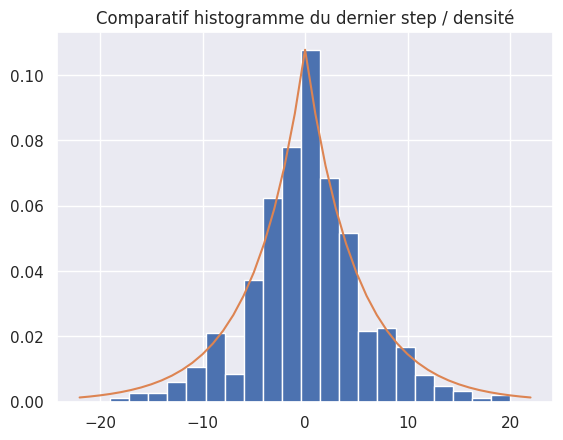

In [4]:
steps = np.arange(0,n_steps)
look = [5,98,22,825]
plt.plot(steps, sample[:,look])
plt.title(f'Aperçu des trajectoires {look}')
plt.show()

x = np.arange(-22,23)
histo = np.histogram(sample[-1], bins=21, density=True)
C = np.max(histo[0])
plt.hist(sample[-1], histo[1], density=True)
plt.plot(x, mu(x)*C)
plt.title("Comparatif histogramme du dernier step / densité")
plt.show()

## Algorithme du recuit simulé


Soit $E$ fini et $H:E \to \mathbf{R}$ une fonction dont on cherche un minimum.
On considère une mesure de Gibbs paramétrée par $T > 0$ de la forme

$$
  \mu_T(x) = \frac{1}{Z_T} \exp \bigl(- \frac{H(x)}{T} \bigr),
$$

où $Z_T$ est la constante de normalisation souvent appelée fonction de partition. Lorsque $T$ tend vers $0$ la mesure $\mu_T$ se concentre sur l'ensemble des minimums de $H$, on considère donc une suite déterministe $(T_n)_{n \ge 1}$ qui tend vers 0 et l'algorithme de Metropolis (inhomogène) suivant:

$$
  Q_n(x, y) = \begin{cases}
    P(x, y) \exp \Bigl( - \frac{(H(y) - H(x))_+}{T_n} \Bigr)
    & \text{si $x \neq y$} \\
    1 - \sum_{z \neq x} Q_n(x, z) & \text{si $x = y$}.
  \end{cases}
$$

où $P$ est une matrice stochastique _irréductible symétrique_.

## Problème du voyageur de commerce

L'énoncé du problème du voyageur de commerce est le suivant : étant donné $N$ points (des « villes ») et les distances séparant chaque point, trouver un chemin de longueur totale minimale qui passe exactement une fois par chaque point et revienne au point de départ. La distance considérée ici est la distance euclidienne.

Soit $N$ villes fixées représentées par un vecteur $V = (V_1, \dots, V_N) \in ([0,1]^2)^N$. Une composante de ce vecteur $V$ est la coordonnée d'une ville dans $[0,1]^2$ et la distance euclidienne $d$ entre 2 villes $V_i$ et $V_j$ est notée dans la suite $d(V_i, V_j)$. Un trajet est identifié par une permutation de $\{1,\dots,N\}$.

Ainsi $E = \mathcal{S}_N$ l'ensemble des permutations de $\{1,\dots,N\}$ et $H$ que l'on appelle ici la longueur d'un trajet $x \in E$ est définie par

$$
  \forall x \in E, \quad H(x)
  = \sum_{i=1}^{N-1} d \bigl(V_{x_i}, V_{x_{i+1}} \bigr)
  + d \bigl(V_{x_N}, V_{x_{1}} \bigr)
$$

Pour information il y a $\operatorname{Card}\big(H(E)\big) = \frac{N !}{2 N}$ longueurs de trajets possibles.

### Question: chargement des données

En python on peut accéder en lecture à un fichier texte en utilisant la fonction `open` qui crée un objet que l'on peut interoger (parcourir) pour lire le contenu du fichier. La méthode `readlines` d'un tel objet crée une liste donc chaque élément est une chaine de caractère. Par exemple la cellule suivante renvoie les 4 premières lignes du fichier `'data/villes.csv'`.

In [5]:
file = open('data/villes.csv', mode = 'r')
lines = file.readlines()
file.close()
lines[:4]

[' x, y\n',
 '0.509881702484563, 0.323756906203926\n',
 '0.304272808600217, 0.0117385489866138\n',
 '0.564815347781405, 0.434346224879846\n']

En utilisant les méthodes `split` et `strip` des chaines de caractères créer un `np.array` `villes` contenants les coordonnées des 30 villes du fichier `data/villes.csv`. Le `np.array` doit donc avoir 30 lignes et 2 colonnes et être composé de réels (`float64`).

_Alternative_: utiliser la fonction `read_csv` du module `pandas`.

In [6]:
villes_list = []
for l in lines[1:]:
    morceau = [float(strg.strip()) for strg in l.split(',')]
    villes_list.append(morceau)

villes = np.array(villes_list)
print(villes)

N = len(villes)

[[0.5098817  0.32375691]
 [0.30427281 0.01173855]
 [0.56481535 0.43434622]
 [0.22358031 0.20260467]
 [0.73053024 0.75112362]
 [0.27159465 0.7126402 ]
 [0.97804911 0.21122158]
 [0.09229808 0.31428773]
 [0.03487644 0.68815773]
 [0.14110214 0.47948362]
 [0.92570904 0.57114005]
 [0.71317047 0.02054912]
 [0.82712149 0.55401652]
 [0.96954033 0.05435883]
 [0.98076194 0.0733982 ]
 [0.01322477 0.80112268]
 [0.01429392 0.26517106]
 [0.97917751 0.75120742]
 [0.49757723 0.87264459]
 [0.07068968 0.20697144]
 [0.19423712 0.24004504]
 [0.42711754 0.0092081 ]
 [0.73337236 0.4213881 ]
 [0.50604737 0.87442028]
 [0.16285993 0.95625381]
 [0.98057777 0.73467298]
 [0.73670048 0.55118886]
 [0.95519137 0.42860425]
 [0.9813112  0.9039921 ]
 [0.35610817 0.79187851]]


### Question: préparatifs

- Définir une fonction `distance(v1, v2)` qui calcule la distance euclidienne entre 2 villes (2 lignes de la matrice `villes`).
- Définir une fonction `H(x)` qui à une configuration $x \in E$ (une permutation de $\{1,\dots,n\}$) renvoie la longueur du trajet (longueur totale en revenant au point de départ).
- Définir une fonction `plot_path(x, ax)` qui affiche le chemin de la configuration `x` dans l'objet `ax` de type `Axes`. Par exemple pour la configuration initiale `x = np.arange(N)` vous devez obtenir ce tracé:
![](img/init.png)

In [7]:
def distance(v1, v2):
    return np.linalg.norm(v1-v2)

def H(x):
    total = np.sum(distance(villes[x[:-1]], villes[x[1:]]))
    # retour au point de départ
    total += distance(villes[x[-1]], villes[x[0]])
    return total

def plot_path(x, ax):
    ax.plot(villes[x,0], villes[x,1])
    ax.plot(villes[x[[-1,0]],0], villes[x[[-1,0]],1], color="red")
    ax.scatter(villes[x,0], villes[x,1], color="orange")

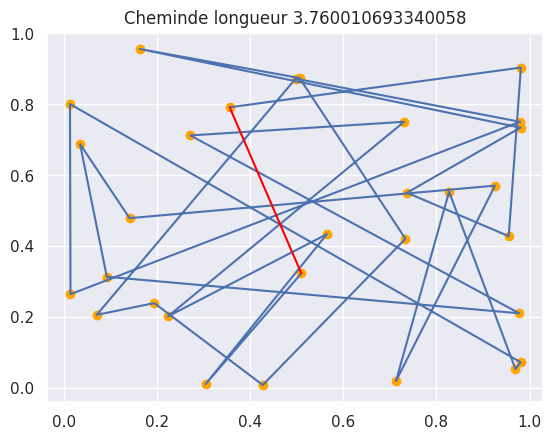

In [8]:
x = np.arange(len(villes))

dist = H(x)

fig, ax = plt.subplots()
plot_path(x, ax)

plt.title(f'Cheminde longueur {dist}')
plt.show()

Pour mettre en oeuvre l'algorithme de recuit simulé il faut choisir une matrice de proposition $P$ pour parcourir l'espace et une suite $(T_n)_{n \ge 1}$ qui tend vers 0. Dans la suite on définit la fonction de température $T$ par
$$
    \forall n \ge 1, \quad T(n) = \frac{0.01}{\log(n+1)}
$$

In [9]:
def T(n):
    return 0.01 / np.log(n+1)

### Question: première matrice de proposition $P_1$

La première matrice de transition que l'on considère pour explorer l'espace des configurations $E = \mathcal{S}_n$ est la plus intuitive. Etant donné un trajet $x \in E$ on tire 2 indices $i$ et $j$ de $\{1,\dots,N\}$ et on échange ces indices c'est à dire qu'on propose le trajet voisin $y$ défini si $i < j$ (par exemple) par
$$
  y = (x_1, \dots, x_{i-1}, x_{j}, x_{i+1},
       \dots, x_{j-1}, x_{i}, x_{j+1}, \dots, x_N)
$$

Définir une fonction `phi_P1` qui code la dynamique basée sur cette proposition. La fonction prend un argument `x` et renvoie un trajet voisin `y`.

**Attention**: l'argument `x` ne doit pas être modifié. Tester votre fonction.

In [10]:
def phi_P1(x):
    # tirage de la permutation et proposition du trajet voisin
    i,j = rng.integers(1,N, size=2)
    y = x.copy()
    y[[i,j]] = x[[j,i]]

    return y

### Question: algorithme du recuit simulé

Définir une fonction `phi_Q(phi_P, T, xn, n)` qui construit le prochain état de la chaine de Markov de transition $Q_n$ sachant qu'on est dans l'état $x_n$ à l'itération $n$.

Ecrire une fonction
```
recuit_simule(phi_P, T=T, x0=np.arange(N), n_iters=3000)
```
qui applique l'algorithme du recuit simulé sur `n_iters` itérations et renvoie le dernier trajet obtenu et la liste de toutes les longueurs obtenues de `0` à `n_iters`.

Tracer le chemin et le graphe des longueurs en fonction de $n$. Répliquer plusieurs fois pour obtenir différents résultats (assez variables).

In [11]:
def phi_Q(phi_P, T, xn, n):
    # calcul du candidat
    candidat_y = phi_P(xn)

    # calcul de la proba d'acceptation
    delta = np.where(H(candidat_y)-H(xn) > 0, H(candidat_y)-H(xn), 0)
    rho = np.exp(-delta/T(n))

    if delta < 0 or rng.uniform()<rho:
        # si delta<0, on a juste P(x,y) et donc on accepte la permutation
        # ou sinon, on accepte la permutation avec proba rho
        return candidat_y
    else:
        # sinon, on refuse la transistion
        return xn

In [12]:
def recuit_simule(phi_P, T=T, x0=np.arange(N), n_iters=3000):
    xn = x0.copy()

    for n in range(1, n_iters+1):
        xn = phi_Q(phi_P, T, xn, n)

    return xn

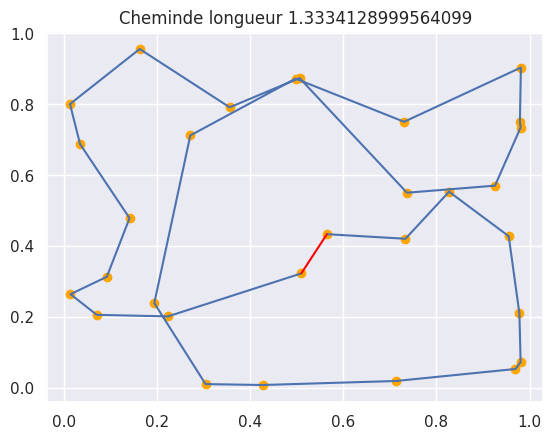

In [14]:
x_P1 = recuit_simule(phi_P1)
dist = H(x_P1)

fig, ax = plt.subplots()
plot_path(x_P1, ax)
plt.title(f'Cheminde longueur {dist}')
plt.show()

### Question: variantes sur la matrice de sélection

- La première variante consiste à supprimer le cas où l'on propose en $n+1$ un trajet similaire à celui en $n$. C'est le cas avec la matrice $P_1$ car $P_1(x, x) = \frac{1}{N} > 0$. Pour cela il suffit de tirer 2 indices $i$ et $j$ de $\{1,\dots,N\}$ sans remise, et on aura donc $i \neq j$.
- La seconde variante consiste à partir de 2 indices $i$ et $j$ différents de
couper le trajet en ces indices et de retourner le trajet entre ces 2 indices.
Ainsi le trajet voisin proposé $y$ à partir de $x$ est défini par
$$
  y = (x_1, \dots, x_{i-1}, x_{j}, x_{j-11},
       \dots, x_{i+1}, x_{i}, x_{j+1}, \dots, x_N)
$$

Coder les fonctions `phi_P2` et `phi_P3` similaires à `phi_P1` qui correspondent aux variantes proposées ci-dessus.

In [15]:
def phi_P2(x):
    # tirage de la permutation et proposition du trajet voisin
    i,j = rng.choice(np.arange(1,N), size=2, replace=False)
    y = x.copy()
    y[[i,j]] = x[[j,i]]

    return y

In [16]:
def phi_P3(x):
    # tirage de la permutation et proposition du trajet voisin
    i,j = rng.choice(np.arange(1,N), size=2, replace=False)
    y = x.copy()

    min = np.min([i,j])
    max = np.max([i,j])
    y[min:max] = x[max-1:min-1:-1]

    return y

### Question: résultats avec ces matrices de proposition

Appliquer l'algorithme de recuit simulé pour chaque stratégie d'exploration proposée. Répliquer plusieurs fois pour obtenir différents résultats.

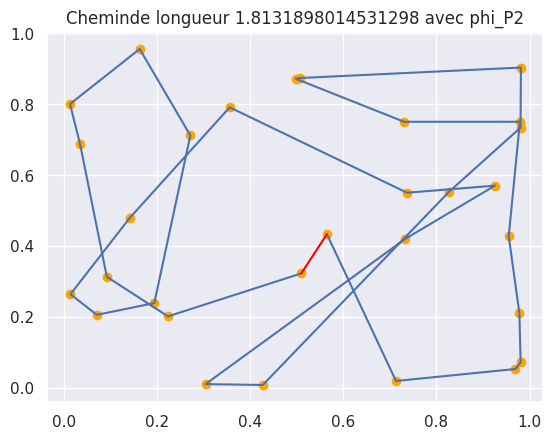

In [17]:
x_P2 = recuit_simule(phi_P2)
dist = H(x_P2)

fig, ax = plt.subplots()
plot_path(x_P2, ax)
plt.title(f'Cheminde longueur {dist} avec phi_P2')
plt.show()

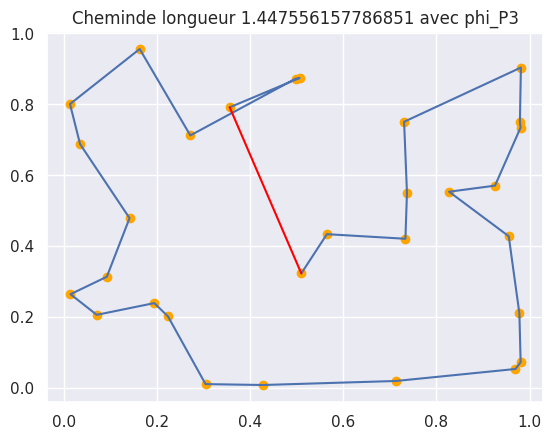

In [18]:
x_P3 = recuit_simule(phi_P3)
dist = H(x_P3)

fig, ax = plt.subplots()
plot_path(x_P3, ax)
plt.title(f'Cheminde longueur {dist} avec phi_P3')
plt.show()

### Question: extensions

Lire le fichier `data/best.csv` qui contient la configuration `x` optimale, c'est à dire de longueur minimale (sauf si vous trouvez mieux!). Tracer ce chemin.  
**Attention:** les villes sont numérotées de 1 à N dans le fichier...

Quelque suggestions pour aller plus loin:

- Reprendre les questions précédentes en faisant varier la fonction de température.  
- Modifier votre code pour construire simultanément $M$ réalisations indépendantes de l'algorithme du recuit simulé.
- Donner la répartition empirique sur $M$ trajectoires des longueurs trouvées pour chaque matrice de proposition $P_1$, $P_2$ et $P_3$.